In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Siamese/Speaker'

/content/drive/My Drive/Siamese/Speaker


In [3]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')
sys.path.insert(0, '../Conference')
sys.path.insert(0, '../Place')

In [4]:
!pip install torchaudio

     |████████████████████████████████| 3.2MB 7.4MB/s 


In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [6]:
MODEL_PATH = '/content/drive/My Drive/Siamese/net.nn'
EPOCH_NUM = 20

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [7]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from torchvision.transforms import Compose
from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                40,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  4874


In [8]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = Conference(DEVICE,
              time=True)

net.load_encoder(size=2)
net.to(DEVICE)

cuda
Encoder loaded


Conference(
  (encoder): Time(
    (avgpool): AvgPool1d(kernel_size=(7,), stride=(4,), padding=(0,))
    (block1): Conv1DBlock(
      (conv): Conv1d(1, 128, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=8, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv1DBlock(
      (conv): Conv1d(128, 256, kernel_size=(7,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=7, stride=8, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv1DBlock(
      (conv1): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(256, 192, kernel_size=(3,), stride=(1,), padding=(1,))
      (acti): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block4):

In [9]:
with torch.no_grad():
  # test
  net.eval()
  # Store the speakers
  speakers_list = testset.get_speakers_list(20)
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list)

In [10]:
import numpy as np

dict_error = {}
dict_nb = {}

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    nb_test = 0

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)

*** Epoch  0  ***


4874it [10:23,  7.82it/s]

accuracy mean  0.2979072630283135 topk 0.40787853918752565  min  0.4070578580221584
Error  0.5921214608124743
{270: 23, 272: 56, 273: 69, 274: 79, 275: 74, 276: 30, 277: 79, 278: 41, 271: 73, 279: 96, 280: 49, 281: 59, 282: 33, 283: 46, 285: 93, 284: 96, 286: 18, 287: 100, 288: 81, 289: 34, 290: 54, 291: 56, 292: 76, 293: 46, 294: 27, 295: 85, 296: 94, 297: 59, 298: 88, 299: 100, 300: 38, 301: 75, 302: 99, 303: 66, 304: 79, 305: 62, 306: 33, 307: 74, 308: 76, 309: 37}
*** Epoch  1  ***



4874it [03:40, 22.10it/s]

accuracy mean  0.3290931473122692 topk 0.4540418547394337  min  0.4489125974558884
Error  0.5459581452605663
{270: 39, 272: 52, 273: 71, 274: 81, 275: 50, 276: 34, 277: 71, 278: 37, 271: 65, 279: 88, 280: 41, 281: 63, 282: 27, 283: 55, 285: 55, 284: 52, 286: 27, 287: 87, 288: 68, 289: 39, 290: 53, 291: 38, 292: 69, 293: 51, 294: 28, 295: 76, 296: 91, 297: 60, 298: 77, 299: 91, 300: 40, 301: 45, 302: 89, 303: 38, 304: 66, 305: 62, 306: 32, 307: 58, 308: 45, 309: 43}
*** Epoch  2  ***



4874it [03:39, 22.25it/s]

accuracy mean  0.350225687320476 topk 0.47845711940910957  min  0.45917111202297906
Error  0.5215428805908905
{270: 39, 272: 58, 273: 73, 274: 70, 275: 36, 276: 42, 277: 50, 278: 43, 271: 65, 279: 73, 280: 37, 281: 64, 282: 27, 283: 52, 285: 52, 284: 40, 286: 33, 287: 54, 288: 52, 289: 43, 290: 56, 291: 40, 292: 70, 293: 54, 294: 30, 295: 60, 296: 76, 297: 48, 298: 70, 299: 73, 300: 41, 301: 31, 302: 68, 303: 27, 304: 70, 305: 62, 306: 38, 307: 50, 308: 29, 309: 53}
*** Epoch  3  ***



4874it [03:37, 22.37it/s]

accuracy mean  0.36869101354123923 topk 0.46635207221994257  min  0.4653262207632335
Error  0.5336479277800574
{270: 41, 272: 62, 273: 81, 274: 64, 275: 32, 276: 52, 277: 44, 278: 49, 271: 56, 279: 55, 280: 43, 281: 64, 282: 39, 283: 55, 285: 52, 284: 36, 286: 35, 287: 47, 288: 50, 289: 49, 290: 61, 291: 35, 292: 72, 293: 57, 294: 29, 295: 50, 296: 79, 297: 48, 298: 70, 299: 51, 300: 41, 301: 35, 302: 66, 303: 33, 304: 69, 305: 67, 306: 40, 307: 51, 308: 23, 309: 53}
*** Epoch  4  ***



4874it [03:36, 22.46it/s]

accuracy mean  0.37443578169881003 topk 0.4643003693065244  min  0.46614690192860075
Error  0.5356996306934756
{270: 39, 272: 56, 273: 81, 274: 62, 275: 28, 276: 56, 277: 41, 278: 50, 271: 57, 279: 42, 280: 46, 281: 60, 282: 42, 283: 54, 285: 56, 284: 35, 286: 34, 287: 39, 288: 52, 289: 54, 290: 60, 291: 36, 292: 73, 293: 59, 294: 31, 295: 55, 296: 78, 297: 51, 298: 70, 299: 34, 300: 43, 301: 39, 302: 60, 303: 33, 304: 67, 305: 68, 306: 43, 307: 54, 308: 23, 309: 56}
*** Epoch  5  ***



4874it [03:36, 22.49it/s]

accuracy mean  0.38448912597455887 topk 0.4688141157160443  min  0.4655313910545753
Error  0.5311858842839556
{270: 36, 272: 54, 273: 81, 274: 57, 275: 31, 276: 53, 277: 35, 278: 49, 271: 57, 279: 39, 280: 46, 281: 64, 282: 44, 283: 56, 285: 58, 284: 37, 286: 36, 287: 37, 288: 47, 289: 52, 290: 61, 291: 39, 292: 72, 293: 57, 294: 31, 295: 51, 296: 80, 297: 49, 298: 70, 299: 28, 300: 44, 301: 37, 302: 59, 303: 34, 304: 70, 305: 68, 306: 44, 307: 51, 308: 28, 309: 52}
*** Epoch  6  ***



4874it [03:34, 22.73it/s]

accuracy mean  0.38797702092736974 topk 0.47066064833812066  min  0.4673779236766516
Error  0.5293393516618794
{270: 36, 272: 50, 273: 80, 274: 57, 275: 31, 276: 52, 277: 35, 278: 51, 271: 60, 279: 39, 280: 47, 281: 61, 282: 42, 283: 54, 285: 55, 284: 37, 286: 34, 287: 39, 288: 50, 289: 51, 290: 59, 291: 38, 292: 72, 293: 59, 294: 33, 295: 60, 296: 77, 297: 51, 298: 70, 299: 26, 300: 40, 301: 39, 302: 63, 303: 32, 304: 70, 305: 67, 306: 43, 307: 51, 308: 29, 309: 52}
*** Epoch  7  ***



4874it [03:32, 22.98it/s]

accuracy mean  0.38243742306114076 topk 0.4595814526056627  min  0.466967583093968
Error  0.5404185473943373
{270: 43, 272: 48, 273: 81, 274: 59, 275: 33, 276: 54, 277: 35, 278: 50, 271: 58, 279: 41, 280: 49, 281: 60, 282: 53, 283: 56, 285: 58, 284: 37, 286: 34, 287: 39, 288: 52, 289: 51, 290: 61, 291: 31, 292: 72, 293: 59, 294: 36, 295: 60, 296: 76, 297: 53, 298: 74, 299: 34, 300: 39, 301: 37, 302: 65, 303: 36, 304: 72, 305: 66, 306: 41, 307: 53, 308: 32, 309: 53}
*** Epoch  8  ***



4874it [03:32, 22.96it/s]

accuracy mean  0.3826425933524826 topk 0.45732457940090276  min  0.4632745178498153
Error  0.5426754205990972
{270: 43, 272: 54, 273: 82, 274: 53, 275: 35, 276: 57, 277: 34, 278: 50, 271: 57, 279: 41, 280: 52, 281: 59, 282: 53, 283: 55, 285: 54, 284: 41, 286: 34, 287: 41, 288: 52, 289: 49, 290: 60, 291: 35, 292: 72, 293: 59, 294: 36, 295: 60, 296: 78, 297: 50, 298: 72, 299: 34, 300: 40, 301: 37, 302: 67, 303: 36, 304: 68, 305: 67, 306: 43, 307: 53, 308: 34, 309: 56}
*** Epoch  9  ***



4874it [03:31, 23.04it/s]


accuracy mean  0.38654082888797703 topk 0.45732457940090276  min  0.45896594173163724
Error  0.5426754205990972
{270: 40, 272: 52, 273: 79, 274: 55, 275: 39, 276: 55, 277: 35, 278: 51, 271: 57, 279: 38, 280: 53, 281: 59, 282: 48, 283: 54, 285: 55, 284: 44, 286: 38, 287: 45, 288: 54, 289: 48, 290: 61, 291: 36, 292: 73, 293: 58, 294: 36, 295: 62, 296: 77, 297: 50, 298: 70, 299: 38, 300: 40, 301: 39, 302: 64, 303: 35, 304: 70, 305: 68, 306: 42, 307: 52, 308: 32, 309: 57}
*** Epoch  10  ***


4874it [03:35, 22.65it/s]

accuracy mean  0.3896183832581042 topk 0.45691423881821913  min  0.4610176446450554
Error  0.5430857611817809
{270: 40, 272: 54, 273: 80, 274: 55, 275: 36, 276: 51, 277: 40, 278: 51, 271: 58, 279: 42, 280: 55, 281: 60, 282: 50, 283: 55, 285: 55, 284: 44, 286: 38, 287: 50, 288: 54, 289: 47, 290: 61, 291: 35, 292: 73, 293: 57, 294: 36, 295: 61, 296: 75, 297: 48, 298: 69, 299: 38, 300: 39, 301: 35, 302: 63, 303: 36, 304: 70, 305: 69, 306: 44, 307: 53, 308: 32, 309: 59}
*** Epoch  11  ***



4874it [03:39, 22.15it/s]

accuracy mean  0.3875666803446861 topk 0.45588838736151005  min  0.4575297496922446
Error  0.54411161263849
{270: 40, 272: 52, 273: 76, 274: 57, 275: 37, 276: 52, 277: 40, 278: 50, 271: 58, 279: 49, 280: 53, 281: 64, 282: 52, 283: 57, 285: 60, 284: 44, 286: 37, 287: 45, 288: 56, 289: 47, 290: 59, 291: 34, 292: 73, 293: 58, 294: 37, 295: 63, 296: 68, 297: 48, 298: 71, 299: 38, 300: 40, 301: 35, 302: 63, 303: 36, 304: 70, 305: 71, 306: 44, 307: 53, 308: 32, 309: 56}
*** Epoch  12  ***



4874it [03:39, 22.19it/s]

accuracy mean  0.38674599917931884 topk 0.4519901518260156  min  0.4509643003693065
Error  0.5480098481739845
{270: 40, 272: 52, 273: 78, 274: 55, 275: 37, 276: 56, 277: 40, 278: 51, 271: 57, 279: 52, 280: 55, 281: 63, 282: 50, 283: 57, 285: 59, 284: 44, 286: 37, 287: 50, 288: 56, 289: 45, 290: 62, 291: 32, 292: 75, 293: 58, 294: 35, 295: 61, 296: 67, 297: 50, 298: 71, 299: 38, 300: 41, 301: 39, 302: 66, 303: 37, 304: 68, 305: 70, 306: 44, 307: 55, 308: 31, 309: 56}
*** Epoch  13  ***



4874it [03:43, 21.80it/s]

accuracy mean  0.3838736151005334 topk 0.44378334017234305  min  0.4521953221173574
Error  0.556216659827657
{270: 38, 272: 54, 273: 78, 274: 59, 275: 36, 276: 55, 277: 40, 278: 52, 271: 57, 279: 52, 280: 56, 281: 60, 282: 53, 283: 59, 285: 61, 284: 44, 286: 37, 287: 52, 288: 60, 289: 45, 290: 62, 291: 35, 292: 76, 293: 59, 294: 36, 295: 64, 296: 69, 297: 53, 298: 75, 299: 42, 300: 41, 301: 39, 302: 67, 303: 37, 304: 69, 305: 69, 306: 42, 307: 56, 308: 32, 309: 58}
*** Epoch  14  ***



4874it [03:42, 21.94it/s]

accuracy mean  0.38366844480919166 topk 0.44111612638489944  min  0.4519901518260156
Error  0.5588838736151005
{270: 41, 272: 56, 273: 79, 274: 55, 275: 39, 276: 50, 277: 41, 278: 52, 271: 58, 279: 55, 280: 59, 281: 59, 282: 58, 283: 60, 285: 61, 284: 42, 286: 36, 287: 52, 288: 62, 289: 45, 290: 62, 291: 38, 292: 76, 293: 57, 294: 38, 295: 64, 296: 70, 297: 53, 298: 75, 299: 42, 300: 41, 301: 41, 302: 68, 303: 37, 304: 68, 305: 70, 306: 42, 307: 57, 308: 34, 309: 58}
*** Epoch  15  ***



4874it [03:42, 21.86it/s]

accuracy mean  0.3820270824784571 topk 0.44255231842429216  min  0.4489125974558884
Error  0.5574476815757078
{270: 41, 272: 56, 273: 79, 274: 57, 275: 40, 276: 52, 277: 41, 278: 51, 271: 58, 279: 53, 280: 58, 281: 65, 282: 44, 283: 60, 285: 62, 284: 42, 286: 36, 287: 50, 288: 58, 289: 47, 290: 59, 291: 39, 292: 76, 293: 58, 294: 39, 295: 64, 296: 70, 297: 53, 298: 77, 299: 40, 300: 41, 301: 39, 302: 67, 303: 37, 304: 69, 305: 70, 306: 42, 307: 56, 308: 34, 309: 58}
*** Epoch  16  ***



4874it [03:44, 21.73it/s]

accuracy mean  0.3883873615100533 topk 0.44050061551087405  min  0.44829708658186296
Error  0.559499384489126
{270: 41, 272: 56, 273: 79, 274: 57, 275: 41, 276: 50, 277: 41, 278: 50, 271: 58, 279: 55, 280: 61, 281: 64, 282: 47, 283: 63, 285: 61, 284: 43, 286: 35, 287: 52, 288: 58, 289: 47, 290: 58, 291: 39, 292: 76, 293: 57, 294: 39, 295: 67, 296: 69, 297: 53, 298: 77, 299: 38, 300: 43, 301: 39, 302: 66, 303: 37, 304: 68, 305: 70, 306: 42, 307: 57, 308: 34, 309: 58}
*** Epoch  17  ***



4874it [03:45, 21.61it/s]

accuracy mean  0.38654082888797703 topk 0.43926959376282315  min  0.44583504308576116
Error  0.5607304062371768
{270: 43, 272: 56, 273: 79, 274: 59, 275: 41, 276: 51, 277: 40, 278: 49, 271: 58, 279: 57, 280: 61, 281: 61, 282: 55, 283: 63, 285: 62, 284: 42, 286: 36, 287: 52, 288: 58, 289: 47, 290: 59, 291: 36, 292: 76, 293: 57, 294: 39, 295: 67, 296: 70, 297: 53, 298: 76, 299: 40, 300: 44, 301: 37, 302: 65, 303: 36, 304: 67, 305: 67, 306: 42, 307: 57, 308: 35, 309: 58}
*** Epoch  18  ***



4874it [03:44, 21.74it/s]

accuracy mean  0.38797702092736974 topk 0.43906442347148134  min  0.44378334017234305
Error  0.5609355765285187
{270: 42, 272: 56, 273: 79, 274: 55, 275: 40, 276: 52, 277: 38, 278: 49, 271: 58, 279: 57, 280: 62, 281: 66, 282: 58, 283: 63, 285: 62, 284: 43, 286: 35, 287: 52, 288: 58, 289: 47, 290: 60, 291: 32, 292: 76, 293: 57, 294: 39, 295: 64, 296: 70, 297: 51, 298: 74, 299: 40, 300: 43, 301: 39, 302: 69, 303: 37, 304: 67, 305: 69, 306: 42, 307: 58, 308: 35, 309: 55}
*** Epoch  19  ***



4874it [03:44, 21.76it/s]


accuracy mean  0.3826425933524826 topk 0.43598686910135415  min  0.44132129667624126
Error  0.5640131308986459
{270: 44, 272: 56, 273: 81, 274: 59, 275: 40, 276: 50, 277: 41, 278: 50, 271: 57, 279: 57, 280: 62, 281: 65, 282: 58, 283: 62, 285: 62, 284: 42, 286: 35, 287: 52, 288: 60, 289: 47, 290: 61, 291: 36, 292: 76, 293: 58, 294: 40, 295: 64, 296: 70, 297: 51, 298: 75, 299: 38, 300: 43, 301: 41, 302: 68, 303: 38, 304: 67, 305: 70, 306: 42, 307: 60, 308: 35, 309: 55}


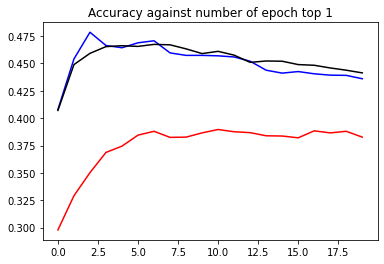

In [11]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='black')


In [12]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))


maximum of min 0.467
maximum of topk 0.478
maximum of mean 0.39
